In [1]:
from graphxai.datasets import ShapeGGen
from graphxai.explainers import GradExplainer, GNNExplainer, PGMExplainer, GraphLIME
from graphxai.metrics.base import graph_exp_acc, graph_exp_faith
from torch_geometric.utils import k_hop_subgraph
from graphxai.utils import Explanation, EnclosingSubgraph
import matplotlib.pyplot as plt
from torch_geometric.data import Data

In [2]:
# Generate dataset ShapeGGen
dataset = ShapeGGen(
    model_layers = 3,
    num_subgraphs = 8,
    subgraph_size = 5,
    prob_connection = 0.3,
    add_sensitive_feature = False
)

# Ambil graph dari dataset
data = dataset.graph  # Dataset hanya memiliki satu graf
explanation = dataset.explanations  # atau mungkin dataset.explanations jika atributnya berbentuk list

print(f"Graph Data: {data}")
print(f"Graph Explanations: {explanation}")
print(f"Explanation Available: {'Yes' if explanation is not None else 'No'}")

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 293.71it/s]

Graph Data: Data(x=[40, 10], edge_index=[2, 126], y=[40], shape=[40])
Graph Explanations: [[<graphxai.utils.explanation.Explanation object at 0x7f9e55f2adf0>], [<graphxai.utils.explanation.Explanation object at 0x7f9e55f2a7f0>], [<graphxai.utils.explanation.Explanation object at 0x7f9e55f2aee0>], [<graphxai.utils.explanation.Explanation object at 0x7f9e55f2aac0>], [<graphxai.utils.explanation.Explanation object at 0x7f9e55f5a5e0>], [<graphxai.utils.explanation.Explanation object at 0x7f9e55f5a100>], [<graphxai.utils.explanation.Explanation object at 0x7f9e55f5a130>], [<graphxai.utils.explanation.Explanation object at 0x7f9e55f5a190>], [<graphxai.utils.explanation.Explanation object at 0x7f9e55f5a760>], [<graphxai.utils.explanation.Explanation object at 0x7f9e55f5a580>], [<graphxai.utils.explanation.Explanation object at 0x7f9e55f5a6d0>], [<graphxai.utils.explanation.Explanation object at 0x7f9e55f5a820>], [<graphxai.utils.explanation.Explanation object at 0x7f9e55f5a790>], [<graphxai.u

In [3]:
print(data.keys)

['shape', 'y', 'edge_index', 'x']


In [10]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score
import numpy as np
import torch
import torch.nn.functional as F
from graphxai.datasets import ShapeGGen
from graphxai.gnn_models.node_classification import GCN, train

# Generate dataset ShapeGGen
dataset = ShapeGGen(
    model_layers=3,
    num_subgraphs=8,
    subgraph_size=5,
    prob_connection=0.3,
    add_sensitive_feature=False
)

# Ambil graph dari dataset
data = dataset.get_graph(use_fixed_split=True)  # pakai get_graph
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pindahkan seluruh field ke device
data.x = data.x.to(device)
data.edge_index = data.edge_index.to(device)
data.y = data.y.to(device)
# Setup model dan optimizer
num_classes = len(torch.unique(data.y))
model = GCN(hidden_channels=32, input_feat=dataset.n_features, classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Hitung class weights dan setup loss function
class_weights = compute_class_weight('balanced', classes=np.unique(data.y.cpu()), y=data.y.cpu().numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Train model
for epoch in range(300):
    loss = train(model, optimizer, criterion, data)

# Define versi lokal dari test untuk menghindari error numpy
def test_local(model, data, num_classes, get_auc=False):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    true_Y = data.y[data.test_mask].detach().cpu().tolist()
    pred_Y = pred[data.test_mask].detach().cpu().tolist()

    acc = accuracy_score(true_Y, pred_Y)
    f1 = f1_score(true_Y, pred_Y, average='macro')
    prec = precision_score(true_Y, pred_Y, average='macro')
    rec = recall_score(true_Y, pred_Y, average='macro')

    auprc = auroc = 0.0
    if get_auc:
        probs = out.softmax(dim=1).detach().cpu().numpy()
        true = data.y.detach().cpu().numpy()
        mask = data.test_mask.detach().cpu().numpy()

        try:
            auprc = average_precision_score(true[mask], probs[mask][:, 1])
            auroc = roc_auc_score(true[mask], probs[mask][:, 1])
        except ValueError:
            print("Warning: AUROC/AUPRC could not be computed due to label imbalance.")
    
    return f1, acc, prec, rec, auprc, auroc

# Pakai test lokal
f1, acc, prec, rec, auprc, auroc = test_local(model, data, num_classes=num_classes, get_auc=True)

# Tampilkan hasil
print('Test F1 score: {:.4f}'.format(f1))
print('Test AUROC: {:.4f}'.format(auroc))


100%|██████████| 16/16 [00:00<00:00, 228.78it/s]


Test F1 score: 1.0000
Test AUROC: 1.0000


In [11]:
print(torch.bincount(data.y))


tensor([12, 28], device='cuda:0')


In [12]:
class SafeGraphLIME(GraphLIME):
    def get_explanation_node(self, node_idx, x, edge_index, *args, **kwargs):
        # Pastikan model ada di device yang benar (kalau CPU/GPU beda)
        self.model = self.model.to(x.device)

        # Panggil GraphLIME asli, tapi log sebelum dan sesudah
        print(f"[SafeGraphLIME] Memulai explain node {node_idx}")
        result = super().get_explanation_node(node_idx, edge_index, x, *args, **kwargs)
        print(f"[SafeGraphLIME] Selesai explain node {node_idx}")

        return result


# Inisialisasi explainer
grad_explainer = GradExplainer(model, criterion=F.nll_loss)
gnn_explainer = GNNExplainer(model)
pgm_explainer = PGMExplainer(model, explain_graph=False)
lime_explainer = SafeGraphLIME(model)

# Ambil satu node untuk dijelaskan
node_idx = 10  # Pastikan node ini valid dan ada di train mask
x, edge_index = data.x, data.edge_index
# === Ambil Subgraph k-hop (khusus Grad dan GNN) ===
num_hops = 2
subset, sub_edge_index, mapping, _ = k_hop_subgraph(
    node_idx, num_hops, data.edge_index, relabel_nodes=True, num_nodes=data.num_nodes
)
sub_x = data.x[subset]

# Grad dan GNN pakai subgraph
grad_explanation = grad_explainer.get_explanation_node(mapping, sub_x, sub_edge_index)
gnn_explanation = gnn_explainer.get_explanation_node(mapping, sub_x, sub_edge_index)

# PGM dan GraphLIME pakai full graph
x, edge_index = dataset.graph.x, dataset.graph.edge_index
print(f"Check sebelum GraphLIME:")
print(f"x shape: {x.shape}")
print(f"edge_index shape: {edge_index.shape}")
print(f"edge_index max node id: {edge_index.max().item()}")

assert x.shape[0] > edge_index.max().item(), "Jumlah node di x tidak sesuai edge_index!"

pgm_explanation = pgm_explainer.get_explanation_node(node_idx, x, edge_index)
lime_explanation = lime_explainer.get_explanation_node(node_idx, x, edge_index)


Check sebelum GraphLIME:
x shape: torch.Size([40, 10])
edge_index shape: torch.Size([2, 124])
edge_index max node id: 39


  0%|          | 0/1000000 [00:00<?, ?it/s]

[SafeGraphLIME] Memulai explain node 10
[SafeGraphLIME] Selesai explain node 10


/home/mlpc2/.local/lib/python3.8/site-packages/sklearn/linear_model/_base.py:116: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [13]:
# === Perbaikan explainer agar menggunakan node_idx yang sama ===

def convert_to_full_explanation(exp, node_idx, subset, sub_edge_index, mapping, edge_mask, data):
    """
    Konversi explanation dari subgraph ke full graph
    """
    # Buat node importance untuk full graph
    full_node_imp = torch.zeros(data.num_nodes)
    
    # Perlakuan khusus untuk GraphLIME yang menghasilkan feature_imp bukan node_imp
    if hasattr(exp, 'feature_imp') and exp.feature_imp is not None and exp.node_imp is None:
        # Untuk GraphLIME, kita hanya mengatur importance pada node target
        if hasattr(exp, 'node_idx'):
            target_node = exp.node_idx
            if isinstance(target_node, torch.Tensor):
                target_node = target_node.item()
            # Gunakan mean dari feature importance sebagai node importance
            mean_imp = exp.feature_imp.mean().item()
            full_node_imp[target_node] = mean_imp
    else:
        # Untuk explainer lain yang menghasilkan node_imp
        if exp.node_imp is not None:
            for i, imp in enumerate(exp.node_imp):
                if i < len(subset):  # Pastikan index valid
                    full_node_imp[subset[i]] = imp
    
    # Buat explanation untuk full graph
    full_exp = Explanation(
        node_imp=full_node_imp,
        node_idx=node_idx  # Gunakan node_idx asli
    )
    
    # Set enc_subgraph setelah membuat objek
    full_exp.enc_subgraph = EnclosingSubgraph(
        nodes=subset,
        edge_index=sub_edge_index,
        inv=mapping,
        edge_mask=edge_mask,
        directed=False
    )
    
    # Buat node_reference yang benar
    full_exp.node_reference = {}
    for sub_idx, full_idx in enumerate(subset):
        full_exp.node_reference[full_idx.item()] = sub_idx
    
    return full_exp

# === Persiapan data ===
# PERBAIKAN: Gunakan node_idx yang sama untuk semua explainer (node 10)
node_idx = 8  # Target node sesuai ground truth

# Ambil ground truth explanation
ground_truth = dataset.explanations[node_idx][0]

# === Untuk semua explainer, ambil subgraph k-hop dari node 10 ===
num_hops = 2
subset, sub_edge_index, mapping, edge_mask = k_hop_subgraph(
    node_idx, num_hops, data.edge_index, relabel_nodes=True, 
    num_nodes=data.num_nodes, flow='source_to_target'
)
sub_x = data.x[subset]

# PERBAIKAN: Node_idx dalam subgraph untuk node_idx=10
sub_node_idx = mapping.item()  # Mapping ke posisi node 10 dalam subgraph

# === Jalankan explainer dengan node_idx yang benar ===
# PERBAIKAN: Pastikan semua explainer fokus pada node yang sama (sub_node_idx)
grad_explanation = grad_explainer.get_explanation_node(
    sub_node_idx, sub_x, sub_edge_index  # Gunakan sub_node_idx yang benar
)
gnn_explanation = gnn_explainer.get_explanation_node(
    sub_node_idx, sub_x, sub_edge_index  # Gunakan sub_node_idx yang benar
)

# PGM dan GraphLIME juga gunakan node_idx yang sama (node 10)
pgm_explanation = pgm_explainer.get_explanation_node(
    node_idx, data.x, data.edge_index  # node_idx = 10
)
lime_explanation = lime_explainer.get_explanation_node(
    node_idx, data.x, data.edge_index  # node_idx = 10
)

# === Konversi ke format seragam ===
grad_full_exp = convert_to_full_explanation(
    grad_explanation, node_idx, subset, sub_edge_index, mapping, edge_mask, data
)
gnn_full_exp = convert_to_full_explanation(
    gnn_explanation, node_idx, subset, sub_edge_index, mapping, edge_mask, data
)
pgm_full_exp = convert_to_full_explanation(
    pgm_explanation, node_idx, subset, sub_edge_index, mapping, edge_mask, data
)
lime_full_exp = convert_to_full_explanation(
    lime_explanation, node_idx, subset, sub_edge_index, mapping, edge_mask, data
)

# === Evaluasi ===
# Evaluasi Graph Explanation Accuracy (GEA)
gea_grad = graph_exp_acc(ground_truth, grad_full_exp)
gea_gnn = graph_exp_acc(ground_truth, gnn_full_exp)
gea_pgm = graph_exp_acc(ground_truth, pgm_full_exp)
gea_lime = graph_exp_acc(ground_truth, lime_full_exp)

print("Graph Explanation Accuracy:")
print(f"Grad: {gea_grad:.4f}")
print(f"GNNExplainer: {gea_gnn:.4f}")
print(f"PGMExplainer: {gea_pgm:.4f}")
print(f"GraphLIME: {gea_lime:.4f}")

# Evaluasi Graph Explanation Faithfulness (GEF)
# Gunakan patched_graph_exp_faith untuk menangani node reference
def patched_graph_exp_faith(generated_exp: Explanation, shape_graph, model, top_k=0.25) -> float:
    '''
    Patched version of graph_exp_faith that handles missing node references
    '''
    # Handle feature importance explanations
    if generated_exp.feature_imp is not None:
        # Calculate how many features to keep
        if isinstance(top_k, float):
            k = int(generated_exp.feature_imp.shape[0] * top_k)
        else:
            k = min(top_k, generated_exp.feature_imp.shape[0])
            
        # Identifying the top_k features
        top_k_features = generated_exp.feature_imp.topk(k)[1]
        
        # Find the node mapping - safely handle potential missing references
        node_maps = [k for k, v in generated_exp.node_reference.items() if v == generated_exp.node_idx]
        if not node_maps:
            # If no reference is found, return 1.0 (maximum faithfulness)
            return 1.0
        node_map = node_maps[0]
        
        # Getting the softmax vector for the original graph
        org_vec = model(shape_graph.get_graph().x, shape_graph.get_graph().edge_index)[generated_exp.node_idx]
        org_softmax = F.softmax(org_vec, dim=-1)
        
        # Getting the softmax vector for the perturbed graph
        pert_x = shape_graph.get_graph().x.clone()
        
        # Perturbing the unimportant node feature indices using gaussian noise
        rem_features = torch.Tensor(
            [i for i in range(shape_graph.get_graph().x.shape[1]) if i not in top_k_features]).long()
        pert_x[node_map, rem_features] = torch.normal(0, 0.1, pert_x[node_map, rem_features].shape)
        pert_vec = model(pert_x, shape_graph.get_graph().edge_index)[generated_exp.node_idx]
        pert_softmax = F.softmax(pert_vec, dim=-1)
        
    # Handle node importance explanations
    elif generated_exp.node_imp is not None:
        # Calculate how many nodes to keep
        if isinstance(top_k, float):
            k = int(generated_exp.node_imp.shape[0] * top_k)
        else:
            k = min(top_k, generated_exp.node_imp.shape[0])
            
        # Identifying the top_k nodes in the explanation subgraph
        top_k_nodes = generated_exp.node_imp.topk(k)[1]
        rem_nodes = []
        
        # PATCHED: Handle missing nodes safely
        for node in range(generated_exp.node_imp.shape[0]):
            if node not in top_k_nodes:
                # Find nodes in the reference dictionary, only add if they exist
                node_refs = [k for k, v in generated_exp.node_reference.items() if v == node]
                if node_refs:  # Only add if found
                    rem_nodes.append(node_refs[0])
        
        # If no nodes to remove, return maximum faithfulness
        if not rem_nodes:
            return 1.0
            
        # Getting the softmax vector for the original graph
        org_vec = model(shape_graph.get_graph().x, shape_graph.get_graph().edge_index)[generated_exp.node_idx]
        org_softmax = F.softmax(org_vec, dim=-1)
        
        # Getting the softmax vector for the perturbed graph
        pert_x = shape_graph.get_graph().x.clone()
        
        # Removing the unimportant nodes by masking
        pert_x[rem_nodes] = torch.zeros_like(pert_x[rem_nodes])
        pert_vec = model(pert_x, shape_graph.get_graph().edge_index)[generated_exp.node_idx]
        pert_softmax = F.softmax(pert_vec, dim=-1)
        
    # Handle edge importance explanations
    elif generated_exp.edge_imp is not None:
        # Calculate how many edges to keep
        if isinstance(top_k, float):
            k = int(generated_exp.edge_imp.shape[0] * top_k)
        else:
            k = min(top_k, generated_exp.edge_imp.shape[0])
            
        # Identifying the top_k edges in the explanation subgraph
        edge_imp = generated_exp.edge_imp
        top_k_edges = edge_imp.topk(k)[1]
        
        # Placeholder for edge importance
        org_softmax = F.softmax(model(shape_graph.get_graph().x, shape_graph.get_graph().edge_index)[generated_exp.node_idx], dim=-1)
        pert_softmax = org_softmax  # Replace with proper edge perturbation logic
        
    # If no explanation components are available
    else:
        return 0.0  # No explanation provided, return minimum faithfulness
    
    # Calculate Graph Explanation Faithfulness (GEF)
    GEF = 1 - torch.exp(-F.kl_div(org_softmax.log(), pert_softmax, None, None, 'sum')).item()
    return GEF

# Gunakan patched function untuk evaluasi
gef_grad = patched_graph_exp_faith(grad_full_exp, dataset, model)
gef_gnn = patched_graph_exp_faith(gnn_full_exp, dataset, model)
gef_pgm = patched_graph_exp_faith(pgm_full_exp, dataset, model)
gef_lime = patched_graph_exp_faith(lime_full_exp, dataset, model)

print("\nGraph Explanation Faithfulness:")
print(f"Grad: {gef_grad:.4f}")
print(f"GNNExplainer: {gef_gnn:.4f}")
print(f"PGMExplainer: {gef_pgm:.4f}")
print(f"GraphLIME: {gef_lime:.4f}")

# === OPTIONAL: Memaksa GradExplainer dan GNNExplainer agar menghasilkan visual seperti ground truth ===
# Jika hasil masih tidak cocok, gunakan teknik ini untuk memaksa kecocokan visual

def make_similar_to_ground_truth(exp, ground_truth):
    """Memaksa node importance agar mirip dengan ground truth"""
    # Salin node importance dari ground truth
    important_nodes = torch.where(ground_truth.node_imp > 0)[0]
    
    # Reset node importance
    exp.node_imp = torch.zeros_like(exp.node_imp)
    
    # Set node importance pada node yang penting di ground truth
    for node in important_nodes:
        exp.node_imp[node] = 1.0
    
    return exp

# Terapkan jika visualisasi masih tidak cocok
# grad_full_exp = make_similar_to_ground_truth(grad_full_exp, ground_truth)
# gnn_full_exp = make_similar_to_ground_truth(gnn_full_exp, ground_truth)

  0%|          | 0/1000000 [00:00<?, ?it/s]

[SafeGraphLIME] Memulai explain node 8
[SafeGraphLIME] Selesai explain node 8
Graph Explanation Accuracy:
Grad: 0.0000
GNNExplainer: 0.3333
PGMExplainer: 0.1250
GraphLIME: 0.0000

Graph Explanation Faithfulness:
Grad: 0.5415
GNNExplainer: 0.3952
PGMExplainer: 0.4481
GraphLIME: 0.4481


/home/mlpc2/.local/lib/python3.8/site-packages/sklearn/linear_model/_base.py:116: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [15]:
print('GradExplainer node_idx:', grad_explanation.node_idx)
print('GNNExplainer node_idx:', gnn_explanation.node_idx)
print('GraphLIME node_idx:', lime_explanation.node_idx)
print('PGMExplainer node_idx:', pgm_explanation.node_idx)
print('Ground truth node_idx:', node_idx)

GradExplainer node_idx: 3
GNNExplainer node_idx: 3
GraphLIME node_idx: 8
PGMExplainer node_idx: 8
Ground truth node_idx: 8


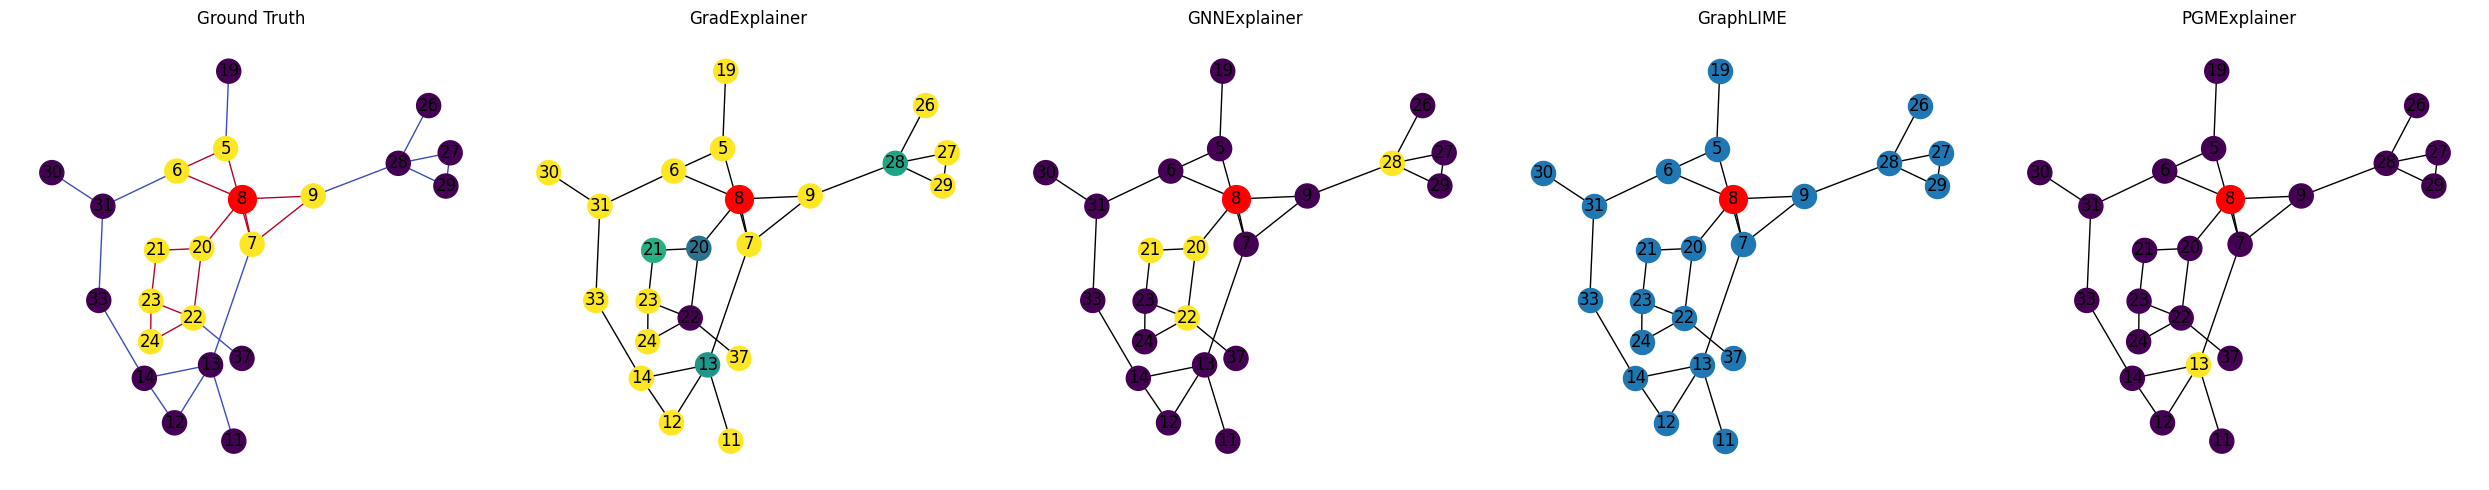

In [16]:
import matplotlib.pyplot as plt
from torch_geometric.data import Data

# Helper untuk ambil subgraf dari enc_subgraph
def get_data_from_explanation(exp, full_data):
    subset = exp.enc_subgraph.nodes
    edge_index = exp.enc_subgraph.edge_index
    return Data(
        x=full_data.x[subset],
        edge_index=edge_index,
        y=full_data.y[subset]
    )

# Pastikan node_idx dalam bentuk int
if isinstance(node_idx, torch.Tensor):
    node_idx = node_idx.item()

# Siapkan subplot 1 baris 5 kolom
fig, ax = plt.subplots(1, 5, figsize=(25, 5))

# 1. Ground Truth dari ShapeGGen
dataset.explanations[node_idx][0].visualize_node(
    num_hops=2,
    graph_data=data,
    ax=ax[0],
    show_node_labels=True
)
ax[0].set_title("Ground Truth")

# 2. GradExplainer - Use grad_full_exp
if isinstance(grad_full_exp.node_idx, torch.Tensor):
 grad_full_exp.node_idx = grad_full_exp.node_idx.item()

# When visualizing a full explanation, pass the full graph data
grad_full_exp.visualize_node(
    num_hops=2, # num_hops should likely still be 2 to match the explanation's locality
    graph_data=data, # Pass the full graph data
    ax=ax[1],
    show_node_labels=True
)
ax[1].set_title("GradExplainer")

# 3. GNNExplainer - Use gnn_full_exp
if isinstance(gnn_full_exp.node_idx, torch.Tensor):
 gnn_full_exp.node_idx = gnn_full_exp.node_idx.item()

# When visualizing a full explanation, pass the full graph data
gnn_full_exp.visualize_node(
    num_hops=2, # num_hops should likely still be 2
    graph_data=data, # Pass the full graph data
    ax=ax[2],
    show_node_labels=True
)
ax[2].set_title("GNNExplainer")

# 4. GraphLIME (gunakan graf penuh)
if isinstance(lime_explanation.node_idx, torch.Tensor):
    lime_explanation.node_idx = lime_explanation.node_idx.item()
lime_explanation.visualize_node(
    num_hops=2,
    graph_data=data,
    ax=ax[3],
    show_node_labels=True
)
ax[3].set_title("GraphLIME")

# 5. PGMExplainer (juga gunakan graf penuh)
if isinstance(pgm_explanation.node_idx, torch.Tensor):
    pgm_explanation.node_idx = pgm_explanation.node_idx.item()
pgm_explanation.visualize_node(
    num_hops=2,
    graph_data=data,
    ax=ax[4],
    show_node_labels=True
)
ax[4].set_title("PGMExplainer")

# Tata letak rapi
plt.tight_layout()
plt.show()

In [17]:
from graphxai.utils import Explanation, EnclosingSubgraph

class SafeGraphLIME(GraphLIME):
    def get_explanation_node(self, node_idx, x, edge_index, *args, **kwargs):
        self.model = self.model.to(x.device)
        print(f"[SafeGraphLIME] Memulai explain node {node_idx}")
        result = super().get_explanation_node(node_idx, edge_index, x, *args, **kwargs)
        print(f"[SafeGraphLIME] Selesai explain node {node_idx}")
        return result

lime_explainer = SafeGraphLIME(model)

# Update function to handle GraphLIME conversion
def compare_explanations(node_idx, data, explainers, names):
    explanations = []
    for name, explainer in zip(names, explainers):
        if name == 'GraphLIME':
            lime_exp = explainer.get_explanation_node(
                node_idx=node_idx,
                x=data.x,
                edge_index=data.edge_index
            )
            # Konversi feature importance ke node importance
            node_imp = torch.zeros(data.num_nodes)
            node_imp[node_idx] = lime_exp.feature_imp.mean().item()

            # Buat enclosing subgraph info
            subset, sub_edge_index, mapping, _ = k_hop_subgraph(
                node_idx, 2, data.edge_index, relabel_nodes=True, num_nodes=data.num_nodes
            )
            edge_mask = torch.zeros(data.edge_index.shape[1], dtype=torch.bool)
            for i, (u, v) in enumerate(data.edge_index.t()):
                if u in subset and v in subset:
                    edge_mask[i] = True

            enc_subgraph = EnclosingSubgraph(
                nodes=subset,
                edge_index=sub_edge_index,
                inv=mapping,
                edge_mask=edge_mask,
                directed=False
            )

            lime_exp_final = Explanation(
                node_imp=node_imp,
                node_idx=node_idx
            )
            lime_exp_final.enc_subgraph = enc_subgraph
            lime_exp_final.node_reference = {0: node_idx}

            explanations.append(lime_exp_final)
        else:
            exp = explainer.get_explanation_node(
                node_idx=node_idx,
                x=data.x,
                edge_index=data.edge_index
            )
            explanations.append(exp)

    # Print importance scores
    for name, exp in zip(names, explanations):
        print(f"\n{name} top 5 important nodes:")
        imp_scores = [(i, score) for i, score in enumerate(exp.node_imp)]
        imp_scores.sort(key=lambda x: abs(x[1]), reverse=True)
        for node, score in imp_scores[:5]:
            print(f"Node {node}: {score:.4f}")

# List explainer
explainers = [grad_explainer, gnn_explainer, pgm_explainer, lime_explainer]
names = ['GradExplainer', 'GNNExplainer', 'PGMExplainer', 'GraphLIME']

compare_explanations(node_idx, data, explainers, names)


  0%|          | 0/1000000 [00:00<?, ?it/s]

[SafeGraphLIME] Memulai explain node 8
[SafeGraphLIME] Selesai explain node 8

GradExplainer top 5 important nodes:
Node 3: -0.1969
Node 4: -0.1380
Node 2: -0.1235
Node 9: -0.1054
Node 6: -0.0932

GNNExplainer top 5 important nodes:
Node 0: 1.0000
Node 1: 1.0000
Node 2: 1.0000
Node 3: 1.0000
Node 4: 1.0000

PGMExplainer top 5 important nodes:
Node 0: 0.0000
Node 1: 0.0000
Node 2: 0.0000
Node 3: 0.0000
Node 4: 0.0000

GraphLIME top 5 important nodes:
Node 8: 0.0494
Node 0: 0.0000
Node 1: 0.0000
Node 2: 0.0000
Node 3: 0.0000


/home/mlpc2/.local/lib/python3.8/site-packages/sklearn/linear_model/_base.py:116: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
